In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
pd.set_option('display.max_columns', None)

In [76]:
df = pd.read_csv('gurgaon_properties_missing_value_imputation.csv')

In [78]:
train_df = df.drop(columns=['society','price_per_sqft'])

<Axes: ylabel='luxury_score'>

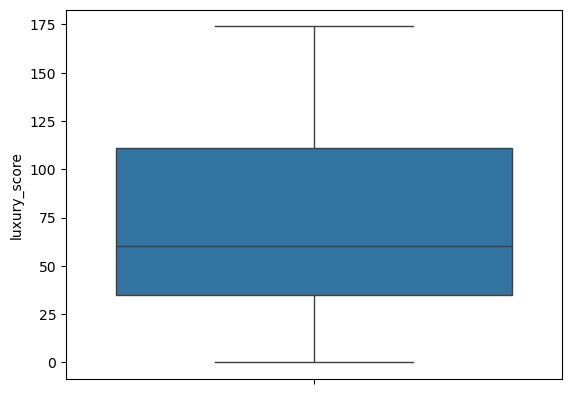

In [80]:
sns.boxplot(df['luxury_score'])

In [81]:
def categorize_luxury(score):
    if 0 <= score < 50:
        return "Low"
    elif 50 <= score < 150:
        return "Medium"
    elif 150 <= score <= 175:
        return "High"
    else:
        return None

In [82]:
train_df['luxury_category'] = train_df['luxury_score'].apply(categorize_luxury)

<Axes: ylabel='floorNum'>

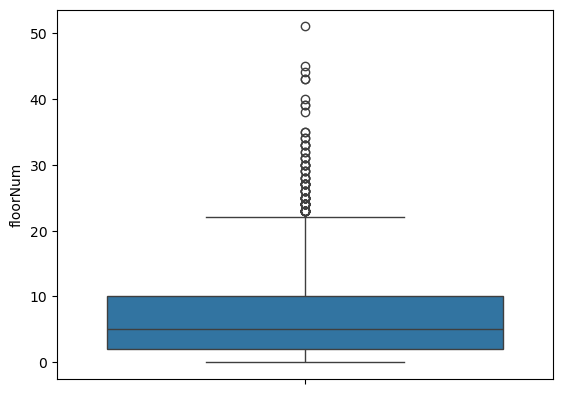

In [86]:
sns.boxplot(df['floorNum'])

In [88]:
def categorize_floor(floor):
    if 0 <= floor <= 2:
        return "Low Floor"
    elif 3 <= floor <= 10:
        return "Mid Floor"
    elif 11 <= floor <= 51:
        return "High Floor"
    else:
        return None

In [90]:
train_df['floor_category'] = train_df['floorNum'].apply(categorize_floor)

In [92]:
train_df.drop(columns=['floorNum','luxury_score'],inplace=True)

In [ ]:
train_df['sector'].unique().tolist()

In [96]:
from sklearn.preprocessing import OrdinalEncoder

# Create a copy of the original data for label encoding
data_label_encoded = train_df.copy()

categorical_cols = train_df.select_dtypes(include=['object']).columns

# Apply label encoding to categorical columns
for col in categorical_cols:
    oe = OrdinalEncoder()
    data_label_encoded[col] = oe.fit_transform(data_label_encoded[[col]])
    print(oe.categories_)

# Splitting the dataset into training and testing sets
X_label = data_label_encoded.drop('price', axis=1)
y_label = data_label_encoded['price']

[array(['flat', 'house'], dtype=object)]
[array(['dwarka expressway', 'gwal pahari', 'manesar', 'sector 1',
       'sector 102', 'sector 103', 'sector 104', 'sector 105',
       'sector 106', 'sector 107', 'sector 108', 'sector 109',
       'sector 10a', 'sector 11', 'sector 110', 'sector 111',
       'sector 112', 'sector 113', 'sector 12', 'sector 13', 'sector 14',
       'sector 15', 'sector 17', 'sector 17a', 'sector 17b', 'sector 2',
       'sector 21', 'sector 22', 'sector 23', 'sector 24', 'sector 25',
       'sector 26', 'sector 27', 'sector 28', 'sector 3',
       'sector 3 phase 2', 'sector 3 phase 3 extension', 'sector 30',
       'sector 31', 'sector 33', 'sector 36', 'sector 36a', 'sector 37',
       'sector 37c', 'sector 37d', 'sector 38', 'sector 39', 'sector 4',
       'sector 40', 'sector 41', 'sector 43', 'sector 45', 'sector 46',
       'sector 47', 'sector 48', 'sector 49', 'sector 5', 'sector 50',
       'sector 51', 'sector 52', 'sector 53', 'sector 54', 'sector 5

## Technique 1 - Correlation Analysis

In [99]:
fi_df1 = data_label_encoded.corr()['price'].iloc[1:].to_frame().reset_index().rename(columns={'index':'feature','price':'corr_coeff'})
fi_df1

,feature,corr_coeff
0,sector,-0.202487
1,price,1.000000
2,bedRoom,0.593980
3,bathroom,0.628344
4,balcony,0.268057
5,agePossession,-0.139493
6,built_up_area,0.752166
7,study room,0.242494
8,servant room,0.394492
9,store room,0.307135


## Technique 2 - Random Forest Feature Importance

In [102]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

,feature,rf_importance
6,built_up_area,0.654284
1,sector,0.104525
0,property_type,0.103640
3,bathroom,0.025748
2,bedRoom,0.021163
8,servant room,0.017226
5,agePossession,0.013082
4,balcony,0.011567
7,study room,0.009465
12,furnishing_type,0.007798


## Technique 3 - Gradient Boosting Feature importances

In [104]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
6,built_up_area,0.688536
0,property_type,0.100292
1,sector,0.099427
2,bedRoom,0.036423
3,bathroom,0.026629
8,servant room,0.024550
9,store room,0.008611
5,agePossession,0.005552
7,study room,0.003192
10,pooja room,0.002584


## Technique 4 - Permutation Importance

In [108]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X_label.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
6,built_up_area,0.785753
0,property_type,0.161372
1,sector,0.124701
3,bathroom,0.013734
8,servant room,0.011948
12,furnishing_type,0.003116
14,floor_category,0.002393
4,balcony,0.000930
11,others,0.000195
13,luxury_category,-0.000161


## Technique 5 - LASSO

In [110]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_label)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_label.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5

,feature,lasso_coeff
6,built_up_area,1.482152
0,property_type,0.742991
3,bathroom,0.423657
9,store room,0.200734
7,study room,0.166962
8,servant room,0.130706
10,pooja room,0.086332
13,luxury_category,0.044567
14,floor_category,-0.000000
5,agePossession,-0.007082


## Technique 6 - RFE

In [126]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

# Get the selected features based on RFE
selected_features = X_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6

,feature,rfe_score
6,built_up_area,0.651806
1,sector,0.107929
0,property_type,0.102135
3,bathroom,0.026855
2,bedRoom,0.023303
8,servant room,0.016919
5,agePossession,0.014123
4,balcony,0.011819
7,study room,0.007683
10,pooja room,0.007497


## Technique 7 - Linear Regression Weights

In [129]:
# Train a linear regression model on the label-encoded and standardized training data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_label)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X_label.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7

,feature,reg_coeffs
6,built_up_area,1.489757
0,property_type,0.756472
3,bathroom,0.505735
9,store room,0.204373
7,study room,0.174781
8,servant room,0.130936
10,pooja room,0.092183
13,luxury_category,0.055657
14,floor_category,-0.006593
5,agePossession,-0.016137


## Technique 8 - SHAP

In [132]:
!pip install shap

In [134]:
import shap

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_label, y_label)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_label)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

shap_values

array([[-6.80986157e-01,  4.60757779e-01, -1.96886788e-03, ...,
         3.55077621e-02,  6.11789931e-02,  5.35245851e-02],
       [-3.77230248e-01, -7.68470914e-01,  1.11298809e-02, ...,
         3.86828384e-02, -1.11260507e-02, -1.19751104e-02],
       [-1.54310832e-01, -8.13718593e-02, -4.80375562e-02, ...,
        -9.63708502e-03, -1.77136097e-02,  2.34100304e-02],
       ...,
       [-2.19918361e-01,  3.97422935e-02, -8.32577928e-03, ...,
        -6.15085643e-03, -1.18631791e-03, -1.08056124e-02],
       [-2.79643838e-01,  1.07074241e+00, -4.06881305e-02, ...,
         5.52953283e-02,  1.00126602e-01, -6.02606836e-02],
       [-6.79833794e-01, -1.29830707e+00, -5.52979835e-02, ...,
        -1.75814334e-02, -1.18321220e-02, -1.56796813e-02]])

In [136]:
fi_df8 = pd.DataFrame({
    'feature': X_label.columns,
    'SHAP_score': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_score', ascending=False)

fi_df8

,feature,SHAP_score
6,built_up_area,1.260881
0,property_type,0.463666
1,sector,0.386692
3,bathroom,0.113417
8,servant room,0.087226
2,bedRoom,0.048435
4,balcony,0.039232
5,agePossession,0.026496
14,floor_category,0.023831
12,furnishing_type,0.020350


In [138]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').merge(fi_df6,on='feature').merge(fi_df7,on='feature').merge(fi_df8,on='feature').set_index('feature')

In [140]:
final_fi_df

,corr_coeff,rf_importance,gb_importance,permutation_importance,lasso_coeff,rfe_score,reg_coeffs,SHAP_score
feature,,,,,,,,
sector,-0.202487,0.104525,0.099427,0.124701,-0.056213,0.107929,-0.064656,0.386692
bedRoom,0.593980,0.021163,0.036423,-0.000897,-0.106280,0.023303,-0.198779,0.048435
bathroom,0.628344,0.025748,0.026629,0.013734,0.423657,0.026855,0.505735,0.113417
balcony,0.268057,0.011567,0.001941,0.000930,-0.034313,0.011819,-0.053561,0.039232
agePossession,-0.139493,0.013082,0.005552,-0.002980,-0.007082,0.014123,-0.016137,0.026496
built_up_area,0.752166,0.654284,0.688536,0.785753,1.482152,0.651806,1.489757,1.260881
study room,0.242494,0.009465,0.003192,-0.000862,0.166962,0.007683,0.174781,0.019886
servant room,0.394492,0.017226,0.024550,0.011948,0.130706,0.016919,0.130936,0.087226
store room,0.307135,0.007126,0.008611,-0.006633,0.200734,0.007140,0.204373,0.016232


In [142]:
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis=0), axis=1)

In [144]:
final_fi_df[['rf_importance','gb_importance','permutation_importance','rfe_score','SHAP_score']].mean(axis=1).sort_values(ascending=False)

feature
built_up_area      0.734910
sector             0.133510
bathroom           0.031500
servant room       0.024024
bedRoom            0.022466
balcony            0.009613
agePossession      0.009200
study room         0.006256
furnishing_type    0.006118
floor_category     0.005549
store room         0.005221
luxury_category    0.004819
pooja room         0.004551
others             0.002264
dtype: float64

In [146]:
# with all the cols
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_label, y_label, cv=5, scoring='r2')

In [148]:
scores.mean()

0.8073107095295896

In [150]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_label.drop(columns=['pooja room', 'study room', 'others']), y_label, cv=5, scoring='r2')

In [152]:
scores.mean()

0.8077937846177236

In [154]:
export_df = X_label.drop(columns=['pooja room', 'study room', 'others'])
export_df['price'] = y_label

In [156]:
export_df.to_csv('gurgaon_properties_post_feature_selection.csv', index=False)

In [158]:
export_df

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category,price
0,0.0,75.0,4,4,4.0,3.0,2833.0,1,0,0,0.0,0.0,4.55
1,0.0,110.0,4,3,3.0,2.0,2007.0,1,0,0,1.0,1.0,1.25
2,0.0,13.0,2,2,0.0,3.0,699.0,0,0,2,1.0,0.0,0.36
3,1.0,64.0,5,6,4.0,2.0,3438.0,1,1,2,1.0,2.0,8.31
4,0.0,95.0,3,3,1.0,0.0,1607.0,0,0,0,2.0,2.0,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3491,0.0,97.0,4,5,4.0,3.0,2390.0,1,0,2,0.0,2.0,2.20
3492,0.0,8.0,3,3,0.0,3.0,2450.0,0,0,2,2.0,0.0,3.90
3493,0.0,4.0,3,3,3.0,3.0,1531.0,0,0,2,1.0,2.0,1.80
3494,0.0,61.0,3,4,4.0,3.0,1875.0,1,0,0,1.0,2.0,4.86
